<a href="https://colab.research.google.com/github/MiguelUrenaPliego/labTopoSAM/blob/main/SAM_mascara_automatica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador automático de máscaras

Si se ejecuta desde colab:

Ir a enotrno de ejecución -> Cambiar tipo de entorno de ejecución: en Acelerador por hadware y seleccionar GPU tipo de GPU T4

Si se ejecuta en local:

Comprobar que se tiene una GPU Nvidia con sus drivers y cuda toolkit instalado
drivers https://www.nvidia.es/Download/index.aspx?lang=es
cuda toolkit https://developer.nvidia.com/cuda-downloads

Fuente:  segment-anything/notebooks/automatic_mask_generator_example.ipynb

In [ ]:
%pip install segment-geospatial leafmap localtileserver #para instalar algunas librerías

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os #importamos algunas librerías de python
import leafmap #leafmap sirve para descargar imágenes de google earth engine https://leafmap.org/#introduction
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Cargar imágenes

Hay dos opciones

### Opción 1: Descarga de imágenes desde google earth

Generamos un mapa interactivo
Veremos una ventana con la imagen de google earth.
La llevamos a la zona que queremos estudiar y con las herramientas de la izquiera hacemos un polígono. Es recomendable estudiar una zona pequeña para que no tarde mucho el procesado.

In [ ]:
m = leafmap.Map(center=[43.2294769, -7.5824514], zoom=17, height="800px") # center=[lat, lon]
m.add_basemap("SATELLITE")
m.add_basemap("HYBRID")
m

Map(center=[43.2294769, -7.5824514], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [ ]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = "No has seleccionado nada"
    print("No has seleccionado nada")
    #bbox = [-122.2659, 37.8682, -122.2521, 37.8741]
bbox

[-7.5861, 43.2299, -7.5823, 43.2322]

bbox es una variable con las coordenadas del polígono que has seleccionado

### Descarga de las imágenes dentro del polígono seleccionado

In [ ]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6
Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


### Opción 2: Cargar imágenes desde archivo local
Puedes cargar tu propia imagen escribiendo la ruta. Debe ser un formato .tif con 3 canales R (rojo) G (verde) B (azul)

In [ ]:
# image = '/path/to/your/own/image.tif'

Vemos las imágenes descargadas sobre el mapa

In [ ]:
m.layers[-1].visible = False #Si da error vuelve a ejecutar la celda de nuevo
m.add_raster(image, layer_name="Image")
m

INFO:large_image:Cannot use memcached for caching.
INFO:large_image:Using python for large_image caching


Map(bottom=12300632.0, center=[43.22963287791912, -7.581676494982878], controls=(ZoomControl(options=['positio…

## Inicialización de SAM
SAM segment anything es un modelo de segmentación de imágenes desarrollado por meta https://github.com/facebookresearch/segment-anything . Tiene una versión especial para imágenes satélite https://samgeo.gishub.org/ .

Para que el procesamiento sea rápido requiere una GPU. En google collab lo hemos configurado ya en el primer paso.

Descargamos SamGeo (Puede tardar unos minutos dependiendo de tu internet)

Metadatos para el modelo de SAM

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86, #precisión para considerar detección en tanto por 1
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

Si queremos usar el modelo por defecto poner None

In [ ]:
sam_kwargs = None

Inicialización del modelo

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=sam_kwargs,
    device = 'cuda' #para trabajar en GPU Nvidia con cuda
)

## Generación automática de la máscara

El resultado se guarda en el formato GEOtiff

unique = True hace que a cada objeto segmentado se le asigne un identificador distinto

In [ ]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

Para ver las máscaras que nos ha generado

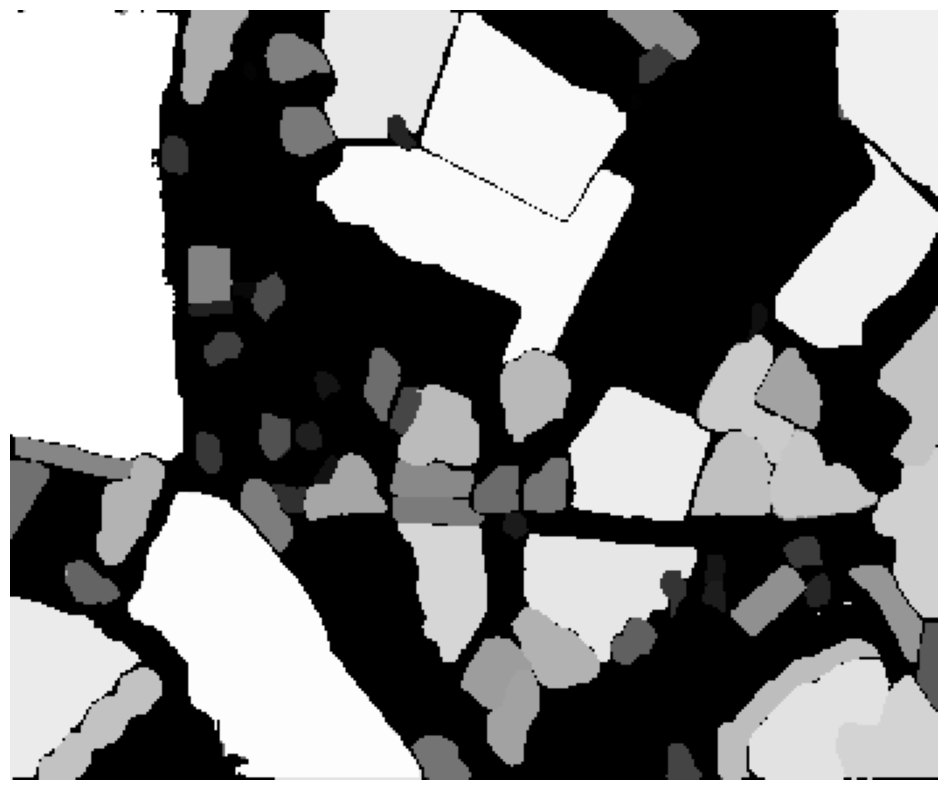

In [ ]:
sam.show_masks(cmap="binary_r")

Para ver los identificadores cada uno con un color distinto

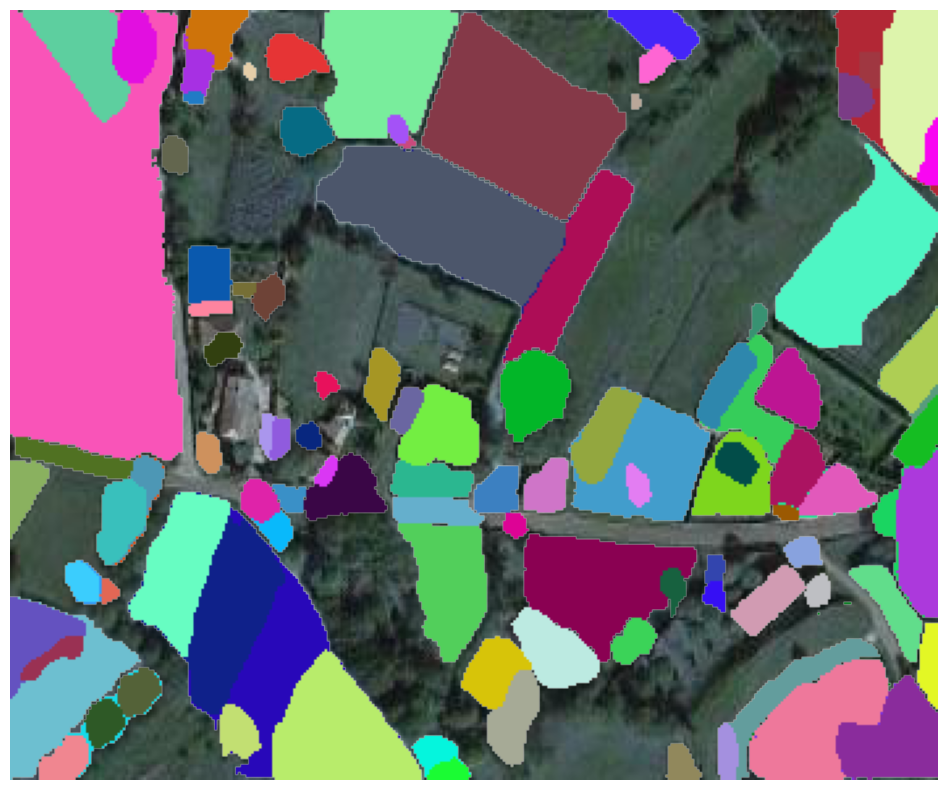

In [ ]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

Comparación de imagen satélite y máscara


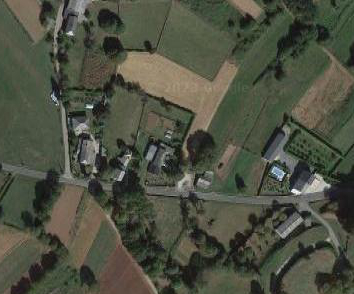
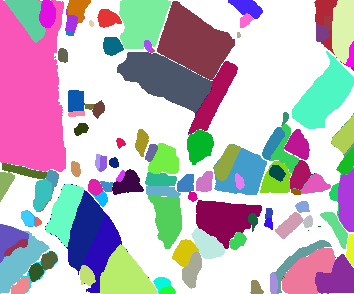

In [ ]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Ver máscara sobre mapa

In [ ]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=61589228.0, center=[14.644067470180794, -90.51144226921912], controls=(ZoomControl(options=['positi…

Comparación de imagen y máscara con slider

In [ ]:
overlay_images(image, "annotations.tif", backend="TkAgg") # No funciona en google Colab

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.


Para guardar máscara en formato vectorial


In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")